# BetterReads: Modelling with the Universal Sentence Encoder

This notebook explores how modelling for the BetterReads algorithm can be accomplished using the [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder) (USE), made freely available through [Tensorflow Hub](https://tfhub.dev/).

We begin by loading the required packages, as well as USE itself.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import tensorflow_hub as hub

In [2]:
# Loads Universal Sentence Encoder locally, from downloaded module
embed = hub.load('../../Universal Sentence Encoder/module/')

# Loads Universal Sentence Encoder remotely, from Tensorflow Hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## Introducing USE

So how does USE work? According to its website, "the Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks." Furthermore, it has been "trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs". This is good for our purposes, since we're interested in clustering our corpora of reviews at the sentence level. Here is an example of how USE works:

In [3]:
example_input = 'This is the way the world ends\nThis is the way the world ends\nThis is the way the world ends\nNot with a bang but a whimper.'
example_output = embed([example_input])
example_output

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-1.78144835e-02, -6.04836568e-02, -6.00747988e-02,
         6.49012178e-02, -4.87822518e-02,  2.52211876e-02,
        -1.26906764e-02,  3.82115953e-02,  7.78134838e-02,
         4.41987589e-02,  5.78998355e-03, -3.50347795e-02,
         2.03568432e-02,  3.38745154e-02,  1.99811831e-02,
        -8.61803144e-02,  2.04321742e-02,  3.33989300e-02,
         2.33055856e-02,  2.69983895e-02, -5.09822480e-02,
         1.14370538e-02,  7.84889311e-02,  1.07127279e-01,
        -6.48521334e-02, -2.85456199e-02, -8.27341899e-03,
        -3.69312204e-02,  4.79229428e-02, -6.92629889e-02,
         5.34384511e-03, -4.52102572e-02,  4.76770662e-02,
        -6.62213117e-02,  3.72504890e-02,  3.53762545e-02,
        -1.40208490e-02,  2.19223835e-02,  2.59532295e-02,
        -9.27677825e-02, -2.95521393e-02, -5.20042740e-02,
        -4.07652482e-02,  3.81045714e-02, -2.08496675e-02,
         5.79222105e-02, -2.33023483e-02, -2.80149803e-02,
      

As we can see, USE encodes our sentence as a 512-dimensional vector, with each dimension having a value between 1 and -1.

## USE & BetterReads

Let us now see how USE can be put to use with our data. We will do this by working on a single example – that is, a single book's collection of full text reviews. Here we will use the example of *Gone Girl*.

<img src='https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1339602131l/8442457.jpg' width=250 align=center>

Remember, the question we want our model to answer is: What are reviewers saying about *Gone Girl*? In other words, what are the most commonly expressed opinions across all of *Gone Girl*'s reviews?

We begin by loading in the data.

In [4]:
# Set path for processed file
file_path = 'data/8442457_gone_girl.csv'

# Read in processed file as dataframe
df = pd.read_csv(file_path)

In [5]:
print(f'This dataset consists of {df.shape[0]} sentences from {df["review_index"].nunique()} reviews\n')
print(df.info())

This dataset consists of 41873 sentences from 8275 reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41873 entries, 0 to 41872
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   book_author   41873 non-null  object 
 1   book_id       41873 non-null  float64
 2   book_title    41873 non-null  object 
 3   date          41873 non-null  object 
 4   rating        41873 non-null  float64
 5   sentence      41873 non-null  object 
 6   review_index  41873 non-null  float64
 7   reviewer_id   41873 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.6+ MB
None


Some summarization: Each row of this dataset corresponds to a full sentence in the original set of reviews (filtered to sentences of more than 5 and less than 50 words, on the assumption that sentences that too short or too long do not express a specific and concrete idea). For our purposes, we want to encode each of these individual sentences as a vector so that we can cluster together semantically similar sentences. Thus, all we have to do is encode each row in the `sentence` column of our dataset.

In [6]:
# Copy sentence column to new variable
sentences = df['sentence'].copy()

# Vectorize sentences
sentence_vectors = embed(sentences)
print(sentence_vectors)

tf.Tensor(
[[-0.01240258  0.02670899 -0.01473068 ... -0.03268288  0.07011374
   0.02979701]
 [-0.01443058 -0.07450303 -0.04109847 ...  0.02828234  0.11195689
   0.00246216]
 [-0.07272263  0.04578361  0.00036584 ... -0.0486478  -0.00171747
   0.01501977]
 ...
 [ 0.04075973 -0.02746006  0.04696274 ... -0.06083205  0.08426022
   0.03423617]
 [ 0.07025012 -0.02207168 -0.01387998 ... -0.00122706 -0.02194622
   0.04943496]
 [ 0.05841347  0.02560622  0.09719509 ... -0.01862008  0.11672609
  -0.02726477]], shape=(41873, 512), dtype=float32)


Great! Each sentence in our dataset has now been encoded as its own 512-dimensional vector.

## Identifying semantic similarity

Recall that we are looking to identify semantically similar sentences, so that we can cluster semantically similar sentences together and find the "heaviest" (or most populated) clusters. This is easy with USE. According to the [official sample notebook](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb), "the semantic similarity of two sentences can be trivially computed as the inner product of the encodings." (This is in part because, as the notebook explains, "the embeddings produced by the Universal Sentence Encoder are approximately normalized.") In other words, USE embeddings are encoded in such a way that **semantically similar sentences are placed in the same region in 512-dimensional space**, such that **the closer their inner product is to 1, the more semantically similar they are.**

Let's see this idea in action, with the use of some sample sentences.

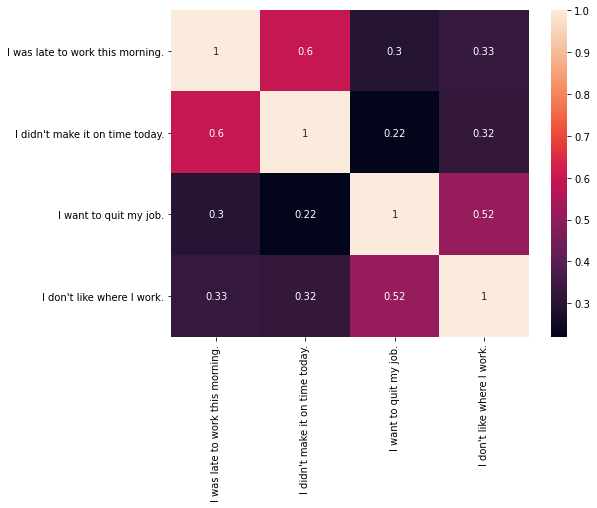

In [7]:
# Create some sample sentences
sample_sentence_a = "I was late to work this morning."
sample_sentence_b = "I didn't make it on time today."
sample_sentence_c = "I want to quit my job."
sample_sentence_d = "I don't like where I work."
sample_sentences = [sample_sentence_a, sample_sentence_b, sample_sentence_c, sample_sentence_d]

# Vectorize sentences
sample_vectors = embed(sample_sentences)

# Take the inner product of the sentence vectors
sample_ips = np.inner(sample_vectors, sample_vectors)

# Visualize the inner products with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(sample_ips, annot=True, xticklabels=sample_sentences, yticklabels=sample_sentences)
plt.show()

Here we can see that the USE embeddings produce the desired results: The first two sentences, both of which have to do with being late for work, are identified as semantically similar, as are the last two sentences, both of which have to do with not liking one's job.

Now let's see how USE can be applied in the case of our review sentences. Let us take a random sentence from our dataset and find the other sentences in our dataset that are most semantically similar to it, according to their USE embeddings.

In [8]:
# Take a random sentence from our dataset as a sample
sample_index = 16
sample_sentence = df.loc[sample_index, 'sentence']

# Take the inner product of that sentence and all other sentences in our dataset
sample_vector = sentence_vectors[sample_index]
sample_ips = np.inner(sample_vector, sentence_vectors)

# Find the sentences with the highest inner product
top_ten_sents = pd.Series(sample_ips).nlargest(11)
top_ten_indices = top_ten_sents.index
top_ten_list = list(sentences[top_ten_indices][1:])

print(f'Sample sentence: "{sample_sentence}"\n')
print(f'Ten most semantically similar sentences in the dataset:\n')
print(*top_ten_list, sep='\n')

Sample sentence: "It was fairly predictable, but I found the storyline to be interesting and kept my attention."

Ten most semantically similar sentences in the dataset:

It was an entertaining read and it kept me engaged in the story, but I found it fairly predictable.
It was a good read but I found the story line somewhat predictable.
I appreciated the plot twists and turns, and it did keep my attention, but overall it was just an okay read.
It was a very quick read and I enjoyed the twists in the plot.
The plot of the story was very well-planned and it kept me interested until the very end.
It started off really suspenseful for me but as I kept reading I felt it was predicable and a little to far fetched.
The story kept me interested throughout and I enjoyed the twists and turns.
A bit predictable, but I liked how the plot felt.
The plot went back and forth between intriguing and boring, so it was enough to keep me reading, but I didn't particularly enjoy it.
After about halfway thr

These are pretty good results! Our sample sentence expressed the idea that the story was good, even though it was predictable, and we find this same idea in several of the sentences identified as most semantically similar. Not all of the identified sentences expressed this idea, however: some found the story unpredictable, noting the plot's twists and turns, and others did not find the story all that good. But on the whole, these are impressive results. The USE embeddings do seem to do a pretty good job of identifying semantically similar sentences.

## Identifying the most commonly expressed opinions

We have now seen how USE embeddings can be employed to identify semantically similar sentences in our dataset. How, then, can we employ USE over our entire dataset, to identify which are the *most commonly* expressed opinions?

Recall that USE embeddings are encoded in such a way that semantically similar sentences are placed in the same region in the 512-dimensional vector space. Because of this, **semantically similar sentences will form clusters in the vector space. The most populated clusters will represent those semantic regions with the greatest number of sentences in them.** Thus, if we wish to find the most commonly expressed opinions in our dataset, we just need to a way to identify these most populated clusters.

Though not a perfect method, k-means clustering provides the easiest and quickest way to identify these clusters. It will divide our complete set of sentence vectors into k number of clusters based on their spatial distribution, such that close groups of points are clustered together. We can then find the centre of each these clusters, and identify the sentences closest to these cluster centres. These sentences will then represent the k most commonly expressed opinions in our dataset. Let's now see this in action.

In [9]:
# Set the number of most commonly expressed opinions to identify
k = 5

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(sentence_vectors);

# Loop through number of clusters
for i in range(k):
    
    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]
    
    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)
    
    # Find the sentence with the highest inner product
    top_index = pd.Series(ips).nlargest(1).index
    top_sentence = sentences[top_index]
    
    print(f'Cluster #{i+1} sentence: "{top_sentence.iloc[0]}"\n')

Cluster #1 sentence: "I did feel the ending was a little anti-climatic but I love that I didn't expect it."

Cluster #2 sentence: "Amy is married to Nick, and the book starts out with Amy going missing."

Cluster #3 sentence: "Dont get me wrong i did enjoy reading this book very much."

Cluster #4 sentence: "The plot twists were clever, and the narrative was engaging, but ultimately the book was so dark and its characters so unappealing that I couldn't come around to enjoying it as much as others did."

Cluster #5 sentence: "It was so disturbingly messed up in a wonderful "I need to keep reading" type of way!"



Here we can see that our model has identified five distinct opinions; roughly, we might summarize these opinions as follows:

1. Disappointing ending, but still loved it
2. Plot details about characters Nick and Amy
3. Enjoyable read
4. Engaging narrative, unappealing characters
5. Messed up, but couldn't stop reading

This is neat, because most of these opinions are making pretty specific points about the book, and not just the sort of generic praise or criticism that one might think would be most common. But do these sentences truly represent clusters of most expressed opinions?

To get a sense of this, let's look at the other nearby sentences in each of these cluster centres. Here we display the ten closest sentences to each cluster centre.

In [10]:
# Loop through number of clusters
for i in range(k):
    
    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]
    
    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)
    
    # Find the sentences with the highest inner products
    top_indices = pd.Series(ips).nlargest(10).index
    top_sentences = list(sentences[top_indices])
    
    print(f'Cluster #{i+1} sentences:\n')
    print(*top_sentences, sep='\n')
    print('\n')

Cluster #1 sentences:

I did feel the ending was a little anti-climatic but I love that I didn't expect it.
I was a little disappointed in the ending, but the rest of the book was so good, it didn't matter.
I was expecting more of a twist in the ending, but i still really enjoyed it.
I was a little bit disappointed in the ending, but otherwise, I loved it.
Definitely a page-turner, but I didn't like the ending.
I wasn't a huge fan of the ending.
That said, I didn't like the ending, and I didn't actually like a lot of the book.
I was kind of disappointed with the ending but it was a real ending.
I don't think I liked the ending, but I am still mulling it over.
I wanted to like it more but the ending really disappointed me.


Cluster #2 sentences:

Amy is married to Nick, and the book starts out with Amy going missing.
I'm just glad to be away from both Nick and Amy; they ruined a compelling and twisty narrative.
Nick was cheating on Amy for over a year and Amy had some secrets even Nick

As we can see, our sentence clusters do indeed exhibit a high degree of semantic similarity, with the possible exception of the fifth cluster. This is as we should expect, given the results we observed earlier with USE embeddings.

But how representative of our dataset are these cluster centres? Do they actually represent commonly expressed opinions, or are they just random points that happen to have a few semantically similar sentences around them? There is no definitive way to answer this question, but here's some indication that our model is working as it should. Instead of looking at the ten closest sentences to our first cluster centre, let's look at *two thousand*.

In [11]:
# Define cluster centre
centre = kmeans_model.cluster_centers_[0]

# Calculate inner product of cluster centre and sentence vectors
ips = np.inner(centre, sentence_vectors)

# Find the sentences with the highest inner products
top_indices = pd.Series(ips).nlargest(2000).index
top_sentences = list(sentences[top_indices])
print(*top_sentences, sep='\n')

I did feel the ending was a little anti-climatic but I love that I didn't expect it.
I was a little disappointed in the ending, but the rest of the book was so good, it didn't matter.
I was expecting more of a twist in the ending, but i still really enjoyed it.
I was a little bit disappointed in the ending, but otherwise, I loved it.
Definitely a page-turner, but I didn't like the ending.
I wasn't a huge fan of the ending.
That said, I didn't like the ending, and I didn't actually like a lot of the book.
I was kind of disappointed with the ending but it was a real ending.
I don't think I liked the ending, but I am still mulling it over.
I wanted to like it more but the ending really disappointed me.
I liked the book, but the ending was not what I expected AT ALL!
I really enjoyed it for the most part, though was disappointed with the ending.
I didn't really love the ending though.
I don't think I liked the ending.
I didn't really love the ending but it was shocking!
I loved all the twi

If we scroll quickly through these sentences we can see that, astonishingly, nearly all of them are expressing an opinion about the book's ending, and typically a negative view. Thus our model is picking up on a real pattern in our data.

## Closing thoughts

These preliminary results provide a "proof of concept" for our model: **the Universal Sentence Encoder combined with k-means clustering can be used to extract the most commonly expressed opinions in a set of reviews.**

What remains to be seen is how this model can be optimized: How do we choose an appropriate value of k? Can better results be achieved by filtering the reviews by their rating? How many reviews are needed for representative clusters to emerge? And can better results be achieved by using other sentence vectorizers? These are questions we will explore in other notebooks.